# Building a customized NER for course names

`Contents`

- Training a annotated data using CRF
- Using Explosion.ai's spacy's PhraseMatcher Parser


## Imports

In [1]:
## Imports
'''Python Version 3.8.0'''

# Standard libs
import os
import sys
import json
import warnings
import re
import io
from io import StringIO
import inspect
import shutil
import ast
import string
import time
import pickle
import glob
import traceback
import multiprocessing
import requests
import logging
import math
import pytz
from itertools import chain
from string import Template
from datetime import datetime, timedelta
from dateutil import parser
import base64
from collections import defaultdict, Counter, OrderedDict
from contextlib import contextmanager
import unicodedata
from functools import reduce
import itertools
import tempfile
from typing import Any, Dict, List, Callable, Optional, Tuple, NamedTuple, Union
from functools import wraps

# Required pkgs
import numpy as np
from numpy import array, argmax
import pandas as pd
import ntpath
import tqdm

# General text correction - fit text for you (ftfy) and others
import ftfy
from fuzzywuzzy import fuzz
from spellchecker import SpellChecker

# scikit-learn
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# scipy
from scipy import spatial, sparse

# NLTK
import nltk
#nltk_model_data_path = "/someppath/"
#nltk.data.path.append(nltk_model_data_path)
from nltk import FreqDist, tokenize, sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *
from nltk.translate.bleu_score import sentence_bleu
print("NLTK loaded.")

# Spacy
import spacy
from spacy import displacy
from spacy.matcher import PhraseMatcher, Matcher
print("Spacy loaded.")

# Pytorch
import torch
from torch import optim, nn
import torch.nn.functional as Functional
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelWithLMHead
from transformers import pipeline
from transformers import AutoModel
print("PyTorch loaded.")

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import offline
%matplotlib inline

# Theme settings
pd.set_option("display.max_columns", 80)
sns.set_context('talk')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

/Users/pranjalpathak/opt/anaconda3/envs/Python_3.8/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


NLTK loaded.


2023-02-17 16:53:07.293621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Spacy loaded.
PyTorch loaded.


## Annotation Schemata

Schemes:

##### BIO scheme 

- B - Beginning, 
- I - Inside
- O - Outside

E.g.
        
        Text = "I read about 529, and I wish to invest in a 529 Savings Account for my kids"
        Here entities are: '529',  '529 Savings Account'
        Tagging output:
            [ O O O B-529 O O O O O O O B-529 I-Savings I-Account O O O ]



##### BILOU scheme 

- B is the Beginning, i.e. first token of a multitoken entity, 
- I stands for Inside, i.e. is the token other than the first one in a multitoken entity, 
- L stands for last, the last token in a multitoken entity, 
- O means outside represents non-entity tokens, 
- U means unit, a unit token entity (if present)


E.g.

     Text = "I read about 529, and I wish to invest in a 529 Savings Account for my kids"
     Here entities are: '529',  '529 Savings Account'
     Tagging output:
           [ O O O U-529 O O O O O O O B-529 I-Savings L-Account O O O ]
            

BILOU makes more sense, is more robust, and is mostly applied across use-cases generally.

## Motivation

Nltk, Spacy, BERTopic are some of the lanugage model classifier used to recognize entities in a given text. 

These entities could be general in nature such as location, phone number, company name which are easily detectable (using Part's of speech tagging and using a dependency parser on it) but for recongizing custom entitites such as finanical ones like `529 Account`, etc we need to train our own NER model, which identifies these keywords used.

Most common and applied approach is to train a Conditonal Random Field model based on Hidden Markov algorithm, and the usual steps are:
- 1. Get loads of training data
- 2. Annotate the data using one of the schemata (BILOU, BIO)
- 3. Augment/Generate 'n' utterances for each entity
- 4. Train a CRF model

## Directory Setup

In [62]:
# print(os.path.join(os.path.dirname(__file__), '..'))
# print(os.path.dirname(os.path.realpath(__file__)))
# print(os.path.abspath(os.path.dirname(__file__)))

In [63]:
root_dir = os.path.abspath("../../")
data_dir = os.path.join(root_dir, "data")
ml_dir = os.path.join(root_dir, "mlEngine")
models_dir = os.path.join(ml_dir, "models")
output_dir = os.path.join(ml_dir, "output")

nlp_resources_fp = os.path.join(models_dir, "resources")
spacy_model_data_path = os.path.join(os.path.join(os.path.join(os.path.join(models_dir, "spacy"), "en_core_web_lg-3.5.0"), "en_core_web_lg"), "en_core_web_lg-3.5.0")
sbert_model_fp = os.path.join(os.path.join(models_dir, "sbert"), "all-distilroberta-v1")

# load spacy
nlp = spacy.load(spacy_model_data_path)  # disabling: nlp = spacy.load(spacy_data_path, disable=['ner'])

## Entities

In [68]:
fn = "courseNames_2023_02_12.csv"
fn_path = os.path.join(os.path.join(root_dir, "data"), fn)

In [69]:
pd.read_csv(fn_path)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 42: invalid start byte

In [8]:
os.listdir("../../../")

['.DS_Store', 'StudyBuff']

In [ ]:
pd.read_csv

In [ ]:
entities = {
    'courses': [
        'machine learning', 'applied statistics', 'statiscs II', 'stastics I', 'spatial geophysiscs', 
        'COURSE_NAME']}


# Storing it to YAML file
with open('objects/entities.yml', 'w') as outfile:
    yaml.dump(entities, outfile, default_flow_style=False)

In [168]:
# Looks like I have to make my own training data

entities = {'courses': ['machine learning', 'applied statistics', 'statiscs II', 'stastics I', 'spatial geophysiscs', 'COURSE_NAME']}

# Storing it to YAML file
with open('../models/entities.yml', 'w') as outfile:
    yaml.dump(entities, outfile, default_flow_style=False)

In [169]:
# Utility function - converts the output of the PhraseMatcher to something usable in training

def offsetter(lbl, doc, matchitem):
    ''' Converts word position to string position, because output of PhraseMatcher returns '''
    one = len(str(doc[0:matchitem[1]]))
    subdoc = doc[matchitem[1]:matchitem[2]]
    two = one + len(str(subdoc))
    
    # This function was misaligned by a factor of one character, not sure why, but
    # this is my solution
    if one != 0:
        one += 1
        two += 1
    return (one, two, lbl)

# Example
offsetter('HARDWARE', nlp('hmm macbooks are great'),(2271554079456360229, 1, 2))

(4, 12, 'HARDWARE')

In [170]:
samples = ['1. What are some similar courses to COURSE_NAME?',
 '2. alternative courses to COURSE_NAME?',
 '3. Can you suggest any courses that are similar to COURSE_NAME?',
 "4. I'm interested in COURSE_NAME, what other courses should I consider?",
 '5. Can you recommend any other courses that are like COURSE_NAME?',
 '6. Are there any related courses to COURSE_NAME that I should check out?',
 '7. Can you suggest any complementary courses to COURSE_NAME?',
 '8. What are some other courses in the same field as COURSE_NAME?',
 "9. Are there any other courses that would be a good fit for someone who's interested in COURSE_NAME?",
 '10. Can you recommend any courses that have a similar curriculum to COURSE_NAME?',
 '11. What are some other courses that cover similar material as COURSE_NAME?',
 '12. Are there any other courses that have a similar focus as COURSE_NAME?',
 '13. Can you suggest any other classes that are similar to COURSE_NAME?',
 '14. Are there any other programs that are similar to COURSE_NAME?',
 '15. Can you recommend any other training programs that are like COURSE_NAME?',
 '16. What are some other educational opportunities that are similar to COURSE_NAME?',
 '17. Are there any other workshops that are similar to COURSE_NAME?',
 '18. Can you suggest any other lectures that are similar to COURSE_NAME?',
 '19. Are there any other seminars that are similar to COURSE_NAME?',
 '20. Can you recommend any other webinars that are like COURSE_NAME?',
 '21. What are some other online courses that are similar to COURSE_NAME?',
 '22. Are there any other distance learning programs that are similar to COURSE_NAME?',
 '23. Can you suggest any other self-paced courses that are similar to COURSE_NAME?',
 '24. Are there any other MOOCs that are similar to COURSE_NAME?',
 '25. Can you recommend any other e-learning programs that are like COURSE_NAME?',
 '26. What are some other degree programs that are similar to COURSE_NAME?',
 '27. Are there any other certification programs that are similar to COURSE_NAME?',
 '28. Can you suggest any other professional development courses that are similar to COURSE_NAME?',
 '29. Are there any other continuing education courses that are similar to COURSE_NAME?',
 '30. Can you recommend any other graduate programs that are like COURSE_NAME?',
 '31. What are some other postgraduate programs that are similar to COURSE_NAME?',
 '32. Are there any other doctoral programs that are similar to COURSE_NAME?',
 "33. Can you suggest any other master's programs that are similar to COURSE_NAME?",
 '34. Are there any other undergraduate programs that are similar to COURSE_NAME?',
 '35. Can you recommend any other vocational programs that are like COURSE_NAME?',
 '36. What are some other technical programs that are similar to COURSE_NAME?',
 '37. Are there any other trade programs that are similar to COURSE_NAME?',
 '38. Are there any other internship programs that are similar to COURSE_NAME?',
 '39. Can you recommend any other fellowship programs that are like COURSE_NAME?',
 '40. Are there any other electives that are similar to COURSE_NAME?',
 '41. COURSE_NAME simillar courses',
 '42. similar to COURSE_NAME what are the courses',
 '43. alternatives for COURSE_NAME in cu boulder', 
 '44. similar coursework to COURSE_NAME, or COURSE_NAME?']

samples = pd.Series(samples).apply(lambda x: "".join(re.findall("^[0-9.]+(.*)", x)).strip()).tolist()

In [171]:
def spacify_row(document, label, entity_keywords):
    ''' Transforming a row to get it from a format of my current training data a
    format that spaCy can understand. It's quite combersome that spaCy only accepts data in this very particular format,
    but that is alright.
    '''
    # Phrase matcher - we use this class from spaCy to locate the text we want to label!
    matcher = PhraseMatcher(nlp.vocab)
    
    # Getting all the hardwares, and the context of how they were used in the Twitter data
    for i in entity_keywords:
        matcher.add(label, None, nlp(i))

    # Getting the matches
    nlp_document = nlp(document)
    matches = matcher(nlp_document)
    
    # Print this if  you want to get a better understanding of this function
#     print([match for match in matches])

    # As you can see, match returns me: [(2271554079456360229, 0, 1)]
    # One match is where one of the tokens in the document matches one of my entity keywords
    # (representiiation of label we passed in, word position in document 1, word position 2)
    entity_list = [offsetter(label, nlp_document, match) for match in matches]
    
    # This is what one row has to look like, so this is what I return:
    # ('what is the price of pool?', {'entities': [(21, 25, 'PrdName')]})
    return (document, {'entities': entity_list})

In [172]:
# entity 1: machine learning
entity_train = pd.Series(samples).apply(lambda x: spacify_row(x, 
                                                   label = 'CORS',
                                                   entity_keywords = entities.get('courses')))

# entity 2: applied data science...

#..

# entity 1200

In [173]:
entity_train_1 = [(i,j) for i,j in entity_train if j['entities'] != []]

In [189]:
s = "can you suggest some similar courses to applied data science in psychology?"

In [190]:
doc = nlp(s)

from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [192]:
sentence = "Daniil Medvedev and Novak Djokovic have built an intriguing rivalry since the Australian Open decider, which the Serb won comprehensively."
doc = nlp(sentence)

from spacy import displacy
displacy.render(doc, style="ent", jupyter=True)

[(X, X.ent_iob_, X.ent_type_) for X in doc if X.ent_type_]

[(Daniil, 'B', 'PERSON'),
 (Medvedev, 'I', 'PERSON'),
 (Novak, 'B', 'PERSON'),
 (Djokovic, 'I', 'PERSON'),
 (the, 'B', 'EVENT'),
 (Australian, 'I', 'EVENT'),
 (Open, 'I', 'EVENT'),
 (Serb, 'B', 'NORP')]

In [150]:
# Now we train the recognizer. 
def train_spacy(train_data, iterations):
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    # if 'ner' not in nlp.pipe_names:
    #     ner = nlp.create_pipe('ner')
    #     nlp.add_pipe(ner, last=True)
       
    # Add labels
    for _, annotations in train_data:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # Disable all pipes other than 'ner' during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        
        train_loss = []
        
        # Go through the training data N times
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            
            # Shuffle training data
            random.shuffle(train_data)
            
            # Iteration level metrics
            losses = {}
            misalligned_count = 0
            
            # Iterating through every Tweet
            for text, annotations in train_data:    
                try:
                    nlp.update(
                        [text],  # batch of texts
                        [annotations],  # batch of annotations
                        drop=0.2,  # dropout - make it harder to memorise data
                        sgd=optimizer,  # callable to update weights
                        losses=losses)
                except ValueError as e:
                    misalligned_count += 1
                    # If it goes here, that means there's a misaligned entity
                    print(f'Ignoring misaligned entity...\n{(text,annotations)}')
                    pass
                
            # Enable this is you want to track misalliged counts
#             print(f'-- misalligned_count (iteration {itn}): {misalligned_count}')
            # Documenting the loss
            train_loss.append(losses.get('ner'))
            print(f'losses (iteration {itn}): {losses}')
            
        # Visualizing the loss
        plt.figure(figsize=(10,6))
        plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
        plt.title('Loss at every iteration')
        plt.xlabel('Iteration Number')
        plt.ylabel('Loss')
        plt.show()
            
    return nlp

# Error rate is going up for the minimum for the path we are currently walking in
# We choose 20 for iterations, but there's a point where if you do it too many times it forgets the
# stuff it knows now

Starting iteration 0
Ignoring misaligned entity...
('alternatives to machine learning..', {'entities': [(16, 32, 'CORS')]})
Ignoring misaligned entity...
('similar to machine learning?', {'entities': [(11, 27, 'CORS')]})
losses (iteration 0): {}


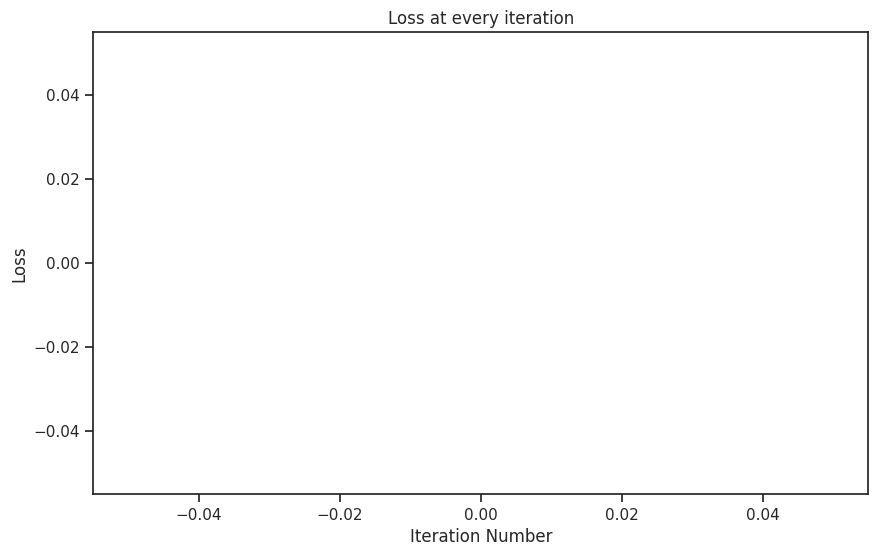

In [151]:
# Training
course_nlp = train_spacy(entity_train, 1)

# Save our trained model into a new directory

In [140]:
s = 'alternatives for COURSE NAME in cu boulder'
s[17:28]

'COURSE NAME'

In [135]:
s = 'Are there any other doctoral programs that are similar to COURSE_NAME?'

In [136]:
s[62:73]

'SE_NAME?'

In [152]:
s = 'alternatives to machine learning..'


In [153]:
s[16:32]

'machine learning'

In [155]:
spacy.__version__

'3.5.0'

In [157]:
# training data
TRAIN_DATA = [
              ("Walmart is a leading e-commerce company", {"entities": [(0, 7, "ORG")]}),
              ("I reached Chennai yesterday.", {"entities": [(19, 28, "GPE")]}),
              ("I recently ordered a book from Amazon", {"entities": [(24,32, "ORG")]}),
              ("I was driving a BMW", {"entities": [(16,19, "PRODUCT")]}),
              ("I ordered this from ShopClues", {"entities": [(20,29, "ORG")]}),
              ("Fridge can be ordered in Amazon ", {"entities": [(0,6, "PRODUCT")]}),
              ("I bought a new Washer", {"entities": [(16,22, "PRODUCT")]}),
              ("I bought a old table", {"entities": [(16,21, "PRODUCT")]}),
              ("I bought a fancy dress", {"entities": [(18,23, "PRODUCT")]}),
              ("I rented a camera", {"entities": [(12,18, "PRODUCT")]}),
              ("I rented a tent for our trip", {"entities": [(12,16, "PRODUCT")]}),
              ("I rented a screwdriver from our neighbour", {"entities": [(12,22, "PRODUCT")]}),
              ("I repaired my computer", {"entities": [(15,23, "PRODUCT")]}),
              ("I got my clock fixed", {"entities": [(16,21, "PRODUCT")]}),
              ("I got my truck fixed", {"entities": [(16,21, "PRODUCT")]}),
              ("Flipkart started it's journey from zero", {"entities": [(0,8, "ORG")]}),
              ("I recently ordered from Max", {"entities": [(24,27, "ORG")]}),
              ("Flipkart is recognized as leader in market",{"entities": [(0,8, "ORG")]}),
              ("I recently ordered from Swiggy", {"entities": [(24,29, "ORG")]})
              ]

In [158]:
for _, annotations in TRAIN_DATA:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [159]:
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [160]:
# Import requirements
import random
from spacy.util import minibatch, compounding
from pathlib import Path

# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 30 iterations
  for iteration in range(30):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
        print("Losses", losses)

ValueError: [E989] `nlp.update()` was called with two positional arguments. This may be due to a backwards-incompatible change to the format of the training data in spaCy 3.0 onwards. The 'update' function should now be called with a batch of Example objects, instead of `(text, annotation)` tuples. 